# 3D plot experimentation

To run plotly/widgets in jupyterlab:
``` shell
pip install jupyterlab "ipywidgets>=7.5"
curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -
sudo apt-get install -y nodejs
jupyter labextension install jupyterlab-plotly@4.14.3
```

## Imports

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [54]:
# Volume array settings
VOL_UNAVAILABLE = -1
VOL_BORDER = 1
VOL_INTERIOR = -2
VOL_EMPTY = 0 

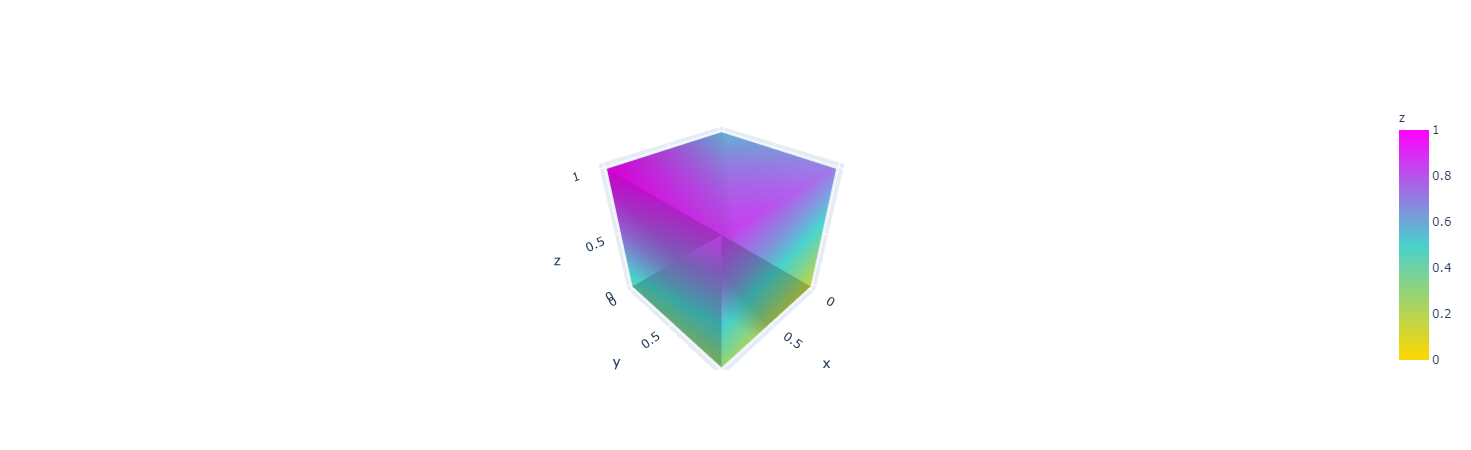

In [55]:
# Mesh cube from https://plotly.com/python/3d-mesh/#mesh-cube
fig = go.Figure(data=[
    go.Mesh3d(
        # 8 vertices of a cube
        x=[0, 0, 1, 1, 0, 0, 1, 1],
        y=[0, 1, 1, 0, 0, 1, 1, 0],
        z=[0, 0, 0, 0, 1, 1, 1, 1],
        colorbar_title='z',
        colorscale=[[0, 'gold'],
                    [0.5, 'mediumturquoise'],
                    [1, 'magenta']],
        # Intensity of each vertex, which will be interpolated and color-coded
        intensity = np.linspace(0, 1, 8, endpoint=True),
        # i, j and k give the vertices of triangles
        i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
        j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
        k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
        name='y',
        showscale=True
    )
])

fig.show()

## Input

``` python
filled_vol = [
    x_coords (np.array),
    y_coords (np.array),
    z_coords (np.array)
] (np.array)
```
``` python
list_of_article_locations = [
    article_code (str),
    article_id (int),
    x_start (int),
    y_start (int),
    z_start (int)
] (list)
```
https://github.com/freichel/willitfit#3d-interactive-plot-plottingplotterpy

In [123]:
# dummy inputs
packages = [["article1",1,[0,5,10,5,3.]],
            ["article2",2,[1,10,15,10,5.]]]

coords = [["article1",0,0,0,0],
          ["article2",1,5,10,0]]

# Voxel approach

In [151]:
def _to_cube(origin):
    '''Convert a voxel at origin into arrays of vertices and triangular faces.
    Args:
        origin - a 3-tuple, the origin of the cube
    Returns:
        (x, y, z, i, j, k) - tuple of list(int)
            x, y, z are the cube vertices
            i, j, k are the cube faces
    '''

    x, y, z = [], [], []
    for v in range(8):
        x.append(origin[0] + v//4)
        y.append(origin[1] + v//2 % 2)
        z.append(origin[2] + v % 2)

    i = [0, 1, 0, 1, 0, 6, 2, 7, 4, 7, 1, 7]
    j = [1, 2, 1, 4, 2, 2, 3, 3, 5, 5, 3, 3]
    k = [2, 3, 4, 5, 4, 4, 6, 6, 6, 6, 5, 5]

    return x, y, z, i, j, k

In [152]:
def mesh_cubes(vox_image: np.ndarray):
    '''Turn a 3d array into a list of plotly.go.Mesh3d objects
    Args:
        vox_image - a numpy.ndarray of binary values
    Returns:
        cubes - a list of cubes as Mesh3d objects
    '''

    # must be a 3-d array
    assert vox_image.ndim == 3

    cubes = []

    # iterate over the entire 3d array
    for i_ind in range(vox_image.shape[0]):
        for j_ind in range(vox_image.shape[1]):
            for k_ind in range(vox_image.shape[2]):
                if vox_image[i_ind, j_ind, k_ind] == 1.:
                    # convert the voxel at this position into a cube
                    cube = _to_cube((i_ind, j_ind, k_ind))
                    # append these vertices and faces as a Mesh3d object
                    cubes.append(
                        go.Mesh3d(
                            x = cube[0],
                            y = cube[1],
                            z = cube[2],
                            i = cube[3],
                            j = cube[4],
                            k = cube[5],
                            hoverinfo='none',
                            color='blue',
                            flatshading=True
                        )
                    )

    return cubes

In [165]:
# x, y, z
voxels = np.zeros((40, 40, 40), dtype=int)
voxels[0:5, 0:10, 0:5] = 1
voxels[5:15, 10:25, 0:10] = 1

In [166]:
x_max = voxels.shape[0]
y_max = voxels.shape[1]
z_max = voxels.shape[2]
cubes = mesh_cubes(voxels)
data = go.Data(cubes)
layout = go.Layout(
    scene = dict(
        aspectmode='cube',
        xaxis = dict(
            type='linear',
            range = [0,x_max],
            showgrid=False,),
        yaxis = dict(
            type='linear',
            range = [0,y_max],
            showgrid=False,),
        zaxis = dict(
            type='linear',
            range = [0,z_max],
            showgrid=False,),
    ),
)
fig = go.Figure(data=data, layout=layout)
fig

In [101]:
# test space
volume_space = np.zeros((40,40,40), dtype=int)
#volume_space[0:10,0:5,0:5] = 1
#volume_space[:,:10,:] = 1
#volume_space[:3,:,:40] = 1

# Item approach

In [125]:
coords

[['article1', 0, 0, 0, 0], ['article2', 1, 5, 10, 0]]

In [126]:
packages

[['article1', 1, [0, 5, 10, 5, 3.0]], ['article2', 2, [1, 10, 15, 10, 5.0]]]

In [145]:
def generate_packages(coords, packages):
    '''Convert coords and dimension info into a list of plotly.go.Mesh3d objects
    Args:
        coords - a list of articles and their start coordinates [[article_code, article_id,x_start,y_start,z_start]]
        packages - a list of articles and their dimensions [[article_code, item_count, package_id, package_length, package_width, package_heigh, package_width]]
    Returns:
        meshes - a list of cuboids as Mesh3d objects
    '''
    
    meshes = []
    
    for i,item in enumerate(coords):
        # corners for each face
        x1 = item[2]
        x2 = x1 + packages[i][2][1]
        y1 = item[3]
        y2 = y1 + packages[i][2][2]
        z1 = item[4]
        z2 = z1 + packages[i][2][3]

        mesh = go.Mesh3d(
            # 8 vertices of a cube
            x=[x1, x1, x2, x2, x1, x1, x2, x2],
            y=[y1, y2, y2, y1, y1, y2, y2, y1],
            z=[z1, z1, z1, z1, z2, z2, z2, z2],

            #i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            #j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            #k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            colorscale='Jet',
            flatshading = True
        )
        meshes.append(mesh)

    return meshes

In [146]:
x_max = volume_space.shape[0]
y_max = volume_space.shape[1]
z_max = volume_space.shape[2]
cubes = mesh_cubes2(coords, packages)
data = cubes
layout = go.Layout(
    scene = dict(
        aspectmode='cube',
        xaxis = dict(
            type='linear',
            range = [0,x_max],
            showgrid=False,),
        yaxis = dict(
            type='linear',
            range = [0,y_max],
            showgrid=False,),
        zaxis = dict(
            type='linear',
            range = [0,z_max],
            showgrid=False,),
    ),
)
fig = go.Figure(data=data, layout=layout)
fig